# Figure 1 Final

Notebook to make figure 1 for ms <br>
by Cascade Tuholske 2020.02.23

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams

In [2]:
#### Load Data

# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-FIGDATA.csv'
#FN_IN = '/home/cascade/projects/UrbanHeat/data/processed/oldworkflow/All_data_Raw406_es_final_pdayadd.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# Set scale
scale = 10**9

# File out
FN_OUT = 'FIG1-ERA5.png'

In [3]:
# Check it
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,5645,1983,1,80796.793810,80796.79381,96123.248169,80796.793810,80796.79381,0.000000
1,1,5645,1989,2,78918.494262,80796.79381,96123.248169,157836.988523,161593.58762,-3756.599097
2,2,5645,1990,3,78605.444337,80796.79381,96123.248169,235816.333011,242390.38143,-6574.048420
3,3,5645,1994,1,76481.266889,80796.79381,96123.248169,76481.266889,80796.79381,-4315.526921
4,4,5645,2005,1,80904.416534,80796.79381,96123.248169,80904.416534,80796.79381,107.622724


In [4]:
#### Drop cities where P1983 == 0
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
#drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city ids for MERRA2 
drop_list = [832, 1732, 5521] # city IDS for ERA5

HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

386920
385526
385424


In [5]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [ ]:
yr_range = max(HI_STATS['year']) - min(HI_STATS['year']) + 1

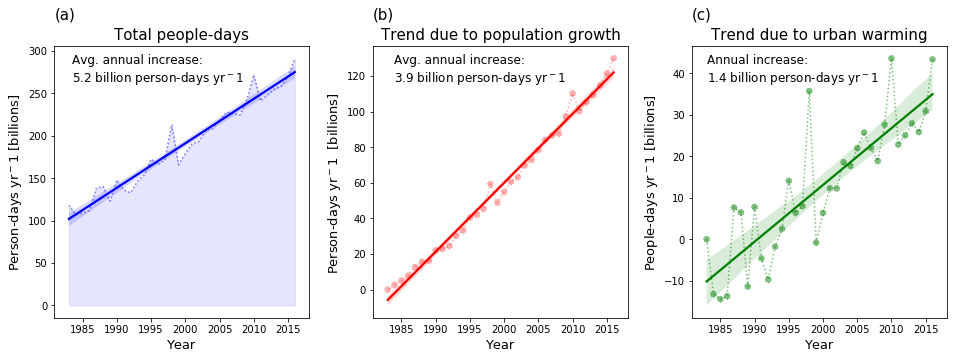

In [6]:
#### Make Figure & Save it

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

## Years to calc increase in pdays / yr 
yr_range = max(HI_STATS['year']) - min(HI_STATS['year']) + 1

## PLOT 1 - People Days
color = 'blue'
data = HI_STATS.groupby('year')['people_days'].sum() / scale
years = list(data.index)
axs[0].plot(data, color = color, linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = color, alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = color, ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total people-days', size = 15 )
axs[0].set_ylabel('Person-days $yr^-1$ [billions]', fontsize = 13)
axs[0].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(HI_STATS, 'people_days')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/10**9, 1))+' billion person-days $yr^-1$'
axs[0].text(0.07, .87, text, transform=axs[0].transAxes, size=12)
axs[0].text(0.00, 1.1, '(a)', transform=axs[0].transAxes, size=15 )

## 2 PLOT 2 - People Days delta pop x days
color = 'red'
data = HI_STATS.groupby('year')['people_days_pop'].sum() / scale
axs[1].scatter(years, data, color = color, linestyle = ':', alpha = 0.3)
axs[1].plot(data, color = color, linestyle = ':', alpha = 0.3)
sns.regplot(years, data, color = color, ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Trend due to population growth', size = 15)
axs[1].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)
axs[1].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(HI_STATS, 'people_days_pop')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/10**9, 1))+' billion person-days $yr^-1$'
axs[1].text(1.25+.08, .87, text, transform=axs[0].transAxes, size=12)
axs[1].text(1.25, 1.1, '(b)', transform=axs[0].transAxes, size=15 )

## PLOT 3 - People Days due to heat
color = 'green'
data = HI_STATS.groupby('year')['people_days_heat'].sum() / scale
pdays83 = data.get(data.index[0])
data = data - pdays83
years = list(data.index)
axs[2].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[2].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Trend due to urban warming', size = 15)
axs[2].set_xlabel('Year', fontsize = 13)
axs[2].set_ylabel('People-days $yr^-1$ [billions]', fontsize = 13)

# Add text
coef, r2, p = lm_func(HI_STATS, 'people_days_heat')
text = 'Annual increase:\n'+str(round(coef/10**9, 1))+' billion person-days $yr^-1$'
axs[2].text(1.25*2-0.04+.1, .87, text, transform=axs[0].transAxes, size=12,);
axs[1].text(1.25*2, 1.1, '(c)', transform=axs[0].transAxes, size=15 )

# save it out
plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')

